# Package

In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data = pd.read_csv('/content/drive/My Drive/data_corr.csv')

In [3]:
# Allows to automatically switch from CPU to GPU
from datetime import timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def is_running_on_gpu():
  if torch.cuda.is_available():
    print("The algorithm is running on GPU.")
  else:
    print("The algorithm is not running on GPU.")

In [4]:
type_float64 = False

if type_float64:
  torch.set_default_dtype(torch.float64)
  np_dtype = np.float64
else:
  torch.set_default_dtype(torch.float32)
  np_dtype = np.float32

## Package PIKL

### PIKL

In [102]:
import time

In [103]:
def normalize(dataset):
    data_min, data_max = np.min(dataset, axis=0), np.max(dataset, axis=0)
    center = (data_min+data_max)/2
    amplitude = data_max-data_min
    return (dataset - center)/amplitude*2*torch.pi

def Sob_elementary(alpha, s, m):
    Sob_elem = torch.cat((torch.arange(-m, 0, device=device), torch.arange(1, m+1, device=device)))
    return alpha*(1+Sob_elem**(2*s))

def Sob_matrix(alpha_list, s_list, m_list):
    d = len(s_list)
    total_length = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    Sob_diag = torch.zeros(total_length, device=device)
    Sob_diag[0] = alpha_list[0]
    idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            Sob_diag[idx] = alpha_list[i + 1]
            idx += 1
        else:
            Sob_diag[idx:idx + 2*m_list[i]] = Sob_elementary(alpha_list[i + 1], s_list[i], m_list[i])
            idx += 2*m_list[i]
    return torch.diag(Sob_diag)


def mat_frequency(m_list, n):
    total_length = 1+sum(2 * m if m != "Linear" else 1 for m in m_list)
    frequencies = torch.zeros(total_length, device=device)

    idx = 1
    for m in m_list:
        if m == "Linear":
            idx += 1
        else:
            frequencies[idx:idx + m] = torch.arange(-m, 0, device=device)
            frequencies[idx + m:idx + 2 * m] = torch.arange(1, m + 1, device=device)
            idx += 2 * m
    return torch.tile(frequencies, (n, 1))

def mat_linear(x_data, m_list, n):
    d = len(m_list)
    total_columns = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    mat = torch.zeros(n, total_columns, device=device)
    col_idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            mat[:, col_idx] = x_data[:, i] - 1
            col_idx += 1
        else:
            col_idx += 2 * m_list[i]
    return mat

def mat_data(x_data, m_list, n):
    d = len(m_list)
    total_columns = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    mat = torch.zeros(n, total_columns, device=device)

    col_idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            mat[:, col_idx] = x_data[:, i]
            col_idx += 1
        else:
            mat[:, col_idx:col_idx + 2 * m_list[i]] = torch.tile(x_data[:, i].view(-1, 1), (1, 2 * m_list[i]))
            col_idx += 2 * m_list[i]
    return mat


def phi_matrix(x_data, m_list):
    n = len(x_data)
    return torch.exp(-1j*torch.mul(mat_data(x_data, m_list, n),mat_frequency(m_list, n))/2)+mat_linear(x_data, m_list, n)

def regression_vector(x_data, y_data, m_list, alpha_list, s_list):
    covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@phi_matrix(x_data, m_list)
    covariance_XY = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@y_data
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+len(x_data)*M, covariance_XY)

def estimation(fourier_coefs, z_data, m_list):
    fourier_coefs = fourier_coefs
    return phi_matrix(z_data, m_list)@fourier_coefs


# A améliorer pour envoyer sur GPU
def transform(df, m_list, fourier_vector, features):
    g_h = pd.DataFrame()
    g_h['Load'] = df['Load']
    g_h['Time']=df['Time']
    g_h['PIKL'] = torch.real(estimation(fourier_vector, torch.tensor(df[features].values, device=device), m_list)).view(-1).cpu().numpy()
    g_h["error"]=df["Load"]-g_h['PIKL']
    phi_mat = phi_matrix(torch.tensor(df[features].values, device=device), m_list)

    current = 1
    for j in range(len(features)):
        if m_list[j]=="Linear":
            linear_coeff = fourier_vector[current].cpu()
            g_h[features[j]] = linear_coeff*torch.tensor(df[features[j]].values).view(-1)
            current+= 1
        else:
            partial_fourier = fourier_vector[current:current+2*m_list[j]]
            g_h[features[j]] = (phi_mat[:, current:current+2*m_list[j]]@partial_fourier).view(-1).cpu()
            current+= 2*m_list[j]
    return g_h



### Grid search PIKL

In [104]:
def calculate_total_length(m_list):
    return 1 + sum(2 * m if m != "Linear" else 1 for m in m_list)

def mat_frequency_h(m_list, n):
    total_length = calculate_total_length(m_list)
    frequencies = torch.zeros(total_length, device=device)

    idx = 1
    for m in m_list:
        if m == "Linear":
            idx += 1
        else:
            freq_range = torch.arange(1, m + 1, device=device)
            frequencies[idx:idx + m] = -freq_range.flip(0)
            frequencies[idx + m:idx + 2 * m] = freq_range
            idx += 2 * m

    return frequencies.unsqueeze(0).unsqueeze(0)

def mat_linear_h(x_data, m_list):
    batch_size, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, col_idx] = x_data[:, :, i] - 1
            col_idx += 1
        else:
            col_idx += 2 * m
    return mat

def mat_data_h(x_data, m_list):
    batch_size, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, col_idx] = x_data[:, :, i]
            col_idx += 1
        else:
            repeated_data = x_data[:, :, i].unsqueeze(2).expand(batch_size, n, 2 * m)
            mat[:, :, col_idx:col_idx + 2 * m] = repeated_data
            col_idx += 2 * m
    return mat

def phi_matrix_h(x_data, m_list):
    batch_size = x_data.size(0)
    n = x_data.size(1)
    return torch.exp(-1j * mat_data_h(x_data, m_list) * mat_frequency_h(m_list, n) / 2) + mat_linear_h(x_data, m_list)


In [135]:
def cov_hourly_m(m_list, data_hourly):
    cov_hourly = []
    x_data, x_test, y_data, ground_truth = data_hourly

    phi_mat = phi_matrix_h(x_data, m_list)
    covariance_matrix_X = torch.bmm(phi_mat.transpose(1, 2).conj(), phi_mat)
    covariance_XY = torch.bmm(phi_mat.transpose(1, 2).conj(), y_data)
    phi_mat_z = phi_matrix_h(x_test, m_list)

    return covariance_matrix_X, covariance_XY, phi_mat_z, ground_truth

def regression_vector_grid(covariance_matrix_X, covariance_XY, M):
    return torch.linalg.solve(covariance_matrix_X+M, covariance_XY)

In [134]:
def hour_formatting(data, date, features_pikl):
    begin_train, end_train, end_test = date["begin_train"], date["end_train"], date["end_test"]
    features, features1, features2 = features_pikl["features_union"], features_pikl["features1"], features_pikl["features2"]
    data_hourly = []

    for h in range(24):
        data_h = data[data['Hour']==h]

        data_h.loc[:,features]=normalize(data_h.loc[:,features]).loc[:,features]
        df_train = data_h[(data_h['Time']>= begin_train)&(data_h['Time']<end_train)]
        df_test = data_h[(data_h['Time']>= end_train)&(data_h['Time']<end_test)]

        if h<8:
            x_data = torch.tensor(df_train[features1].values, device=device)
            x_test = torch.tensor(df_test[features1].values, device=device)
        else :
            x_data = torch.tensor(df_train[features2].values, device=device)
            x_test = torch.tensor(df_test[features2].values, device=device)

        y_data = torch.tensor(df_train['Load'].values, device=device).view(-1,1)*(1+0*1j)
        ground_truth = torch.tensor(df_test['Load'].values, device=device)

        if type_float64:
          data_hourly.append([x_data, x_test, y_data, ground_truth])
        else:
          data_hourly.append([x_data.to(torch.float32), x_test.to(torch.float32), y_data.to(torch.complex64), ground_truth.to(torch.float32)])

    x_data = torch.stack([data_hourly[i][0] for i in range(24)])
    x_test = torch.stack([data_hourly[i][1] for i in range(24)])
    y_data = torch.stack([data_hourly[i][2] for i in range(24)])
    ground_truth = torch.stack([data_hourly[i][3] for i in range(24)])
    return x_data, x_test, y_data, ground_truth


In [107]:
def sob_effects(features_pikl, m_list, s_list, data_hourly):
    features_type = features_pikl["features_type"]
    n_param = len(features_type)+1
    one_list = [1. for i in range(n_param)]
    select_dim = [[0 for i in range(n_param)] for i in range(n_param)]
    for i in range(n_param):
        select_dim[i][i] = 1
    sobolev_effects = []
    for i in range(n_param):
        sobolev_effects.append(Sob_matrix(select_dim[i], s_list, m_list))
    sobolev_effects = torch.stack(sobolev_effects)*len(data_hourly[0][0])
    return sobolev_effects

In [108]:
def PIKL(data, hyperparameters, cov_hourly, M_stacked):
    m_list, s_list, alpha_list = hyperparameters["m_list"], hyperparameters["s_list"], hyperparameters["alpha_list"]

    fourier_vectors= torch.linalg.solve(cov_hourly[0]+M_stacked, cov_hourly[1])
    estimators = torch.matmul(cov_hourly[2], fourier_vectors).squeeze(-1)
    mae_houlry = torch.mean(torch.abs(estimators-cov_hourly[3]), dim=1)
    mae = torch.mean(mae_houlry)
    return mae, fourier_vectors, mae_houlry

In [109]:
def create_grid(features_pikl, n, grid_parameters):
    features_type = features_pikl["features_type"]
    grid_size_m, grid_size_p, grid_step_p = grid_parameters["grid_size_m"], grid_parameters["grid_size_p"], grid_parameters["grid_step_p"]
    number_regression = 0

    m_range, alpha_const, alpha_grid_range, s_list = [], [[10**(-30)]], [], [] # Initializing power with the offset
    for feature_type in features_type:
        if feature_type in ["bool", "linear"]:
            m_range.append(["Linear"]), alpha_const.append([10**(-30)]), s_list.append("*")
        elif feature_type[:11] == "categorical":
            n_categories = int(feature_type[11:])
            m_range.append([n_categories//2+n_categories%2]), alpha_const.append([10**(-30)]), s_list.append(0)
        elif feature_type == "regression":
            m_ini = grid_parameters["m_ini"]
            power_ini = -int(np.log(n)/np.log(10))
            m_possibilities = list(range(m_ini-grid_size_m, m_ini+grid_size_m+1))

            power_possibilities = np.arange(power_ini-grid_size_p*grid_step_p, power_ini+(grid_size_p+1)*grid_step_p, grid_step_p)
            m_range.append(m_possibilities), alpha_grid_range.append(10**power_possibilities), s_list.append(2)
            number_regression+=1
    grid_m = list(itertools.product(*m_range))

    grid_a = torch.cartesian_prod(*torch.tensor(np.array(alpha_grid_range, dtype=np_dtype), device=device)).view(-1, number_regression, 1, 1)
    alpha_const = torch.tensor(alpha_const, device=device).view(-1, 1, 1)

    regression_mask = [i+1 for i in range(len(features_type)) if features_type[i] == "regression"]
    non_reg_mask = [0]+[i+1 for i in range(len(features_type)) if features_type[i] != "regression"]
    return grid_m, alpha_const, grid_a, s_list, regression_mask, non_reg_mask


def grid_search_pikl(data, date, features_pikl, n, grid_parameters):
    grid_m, alpha_const, grid_a, s_list, regression_mask, non_reg_mask = create_grid(features_pikl, n, grid_parameters)
    len_grid_m, len_grid_a, counter = len(grid_m), len(grid_a), 0

    grid_a = grid_a.split(grid_parameters["batch_size"], dim=0)

    mae_min = torch.inf
    mae_h=[]
    m_list_opt, power_list_opt, mae_list_opt, fourier_opt = [], [], [], []

    data_hourly = hour_formatting(data, date, features_pikl)

    for m_list in grid_m:
      cov_hourly = cov_hourly_m(m_list, data_hourly)

      sobolev_effects = sob_effects(features_pikl, m_list, s_list, data_hourly)
      mul1 = alpha_const*(sobolev_effects[non_reg_mask,:].unsqueeze(0))

      for grid_a_batch in grid_a:
        mul2 = grid_a_batch*(sobolev_effects[regression_mask,:].unsqueeze(0))
        sobolev_matrices = torch.sum(mul1, dim=1, keepdim=True) + torch.sum(mul2, dim=1, keepdim=True)
        fourier_vectors= torch.linalg.solve(cov_hourly[0].unsqueeze(0)+sobolev_matrices, cov_hourly[1].unsqueeze(0))
        estimators = torch.matmul(cov_hourly[2].unsqueeze(0), fourier_vectors).squeeze(-1)
        errors = torch.abs(cov_hourly[3].unsqueeze(0)-estimators)
        mae_hourly =  torch.mean(errors, dim=2)
        mae_mean = torch.mean(mae_hourly, dim=1)
        min_mae_index = torch.argmin(mae_mean)

        if mae_mean[min_mae_index] < mae_min:
              m_list_opt, alpha_list_opt, mae_opt, fourier_opt, mae_h = m_list, grid_a_batch[min_mae_index], mae_mean[min_mae_index], fourier_vectors[min_mae_index], mae_hourly[min_mae_index]
              mae_min = mae_mean[min_mae_index]
      print(str(counter*len_grid_a)+"/"+str(len_grid_m*len_grid_a))
      counter+=1
    alpha_opt = torch.zeros(len(regression_mask)+len(non_reg_mask), device=device)
    alpha_opt[regression_mask] = alpha_list_opt.view(-1)
    alpha_opt[non_reg_mask] = alpha_const.view(-1)
    return m_list_opt, alpha_opt, s_list, mae_opt, fourier_opt, mae_h




### Significativité des effets

In [110]:
def P_matrix(x_data, m_list, alpha_list, s_list):
    covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@phi_matrix(x_data, m_list)
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+len(x_data)*M, torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1)))

def sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data):
    n = len(x_data)
    P = P_matrix(x_data, m_list, alpha_list, s_list)
    tr = torch.real(torch.trace(phi_matrix(x_data, m_list)@P))
    interpolation = torch.real(estimation(fourier_vector, x_data, m_list)).view(-1)
    err = torch.sum(torch.square(torch.abs(interpolation-y_data.view(-1)))).item()
    return 1/(n-tr)*err

def t_test(x_data, m_list, alpha_list, s_list, fourier_vector, y_data):
    t_stat = []
    P = P_matrix(x_data, m_list, alpha_list, s_list)
    mat = P@phi_matrix(x_data, m_list)@ torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@ torch.conj_physical(torch.transpose(P, 0,1))
    sigma = sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data).item()
    for i in range(len(fourier_vector)):
        t_stat.append(fourier_vector[i].item()/np.sqrt(mat[i,i].item()*sigma))
    return np.array(t_stat)

def print_t_test(test, features, m_list):
    print("--------------------------")
    print("T-tests")
    print("Offset: t-test = "+str(np.abs(test[0])), ", significant (5%) = "+ str(np.abs(test[0]) > 2))
    index = 0
    for i in range(len(features)):
        print('Feature '+ features[i])
        if m_list[i]=='Linear':
            index+=1
            print("Linear coefficient t-test = "+str(np.abs(test[index])), ", significant (5%) = "+ str(np.abs(test[index]) > 2))
        else:
            for j in range(2*m_list[i]):
                index+=1
                print("Fourier coefficient "+str(j)+" t-test = "+str(np.abs(test[index])), ", significant (5%) = "+ str(np.abs(test[index]) > 2))
    print("--------------------------")
    return

In [111]:
def print_effect(data, dates, features_pikl, hyperparameters, fourier_vectors, h):
    m_list, s_list, alpha_list = hyperparameters["m_list"], hyperparameters["s_list"], hyperparameters["alpha_list"]
    begin_train, end_train = dates["begin_train"], dates["end_train"]

    if h<8:
        features = features_pikl["features1"]
    else:
        features = features_pikl["features2"]

    df_h = data[data['Hour'] == h]
    df_h=df_h[features+['Load','Time']]
    df_h.loc[:,features]=normalize(df_h[features]).loc[:,features]
    df_h = df_h[(df_h['Time']>= begin_train)&(df_h['Time']<end_train)]

    x_data = torch.tensor(df_h[features].values, device=device)
    y_data = torch.tensor(df_h['Load'].values, device=device).view(-1,1)*(1+0*1j)
    test=t_test(x_data, m_list, alpha_list, s_list, fourier_vectors[h], y_data)
    print_t_test(test, features, m_list)

    g_h=transform(df_h, m_list, fourier_vectors[h], features)

    for feature in features:
        print(feature)
        plt.figure()
        plt.scatter(df_h[feature], np.real(g_h[feature]))
        plt.show()




## Time-varying PIKL

In [14]:
def mat_weight_kalman(x_data, m_list, n):
    mat = torch.tensor([[1] for i in range(n)], device=device)
    d = len(m_list)
    for i in range(d):
        mat = torch.cat((mat, torch.tile(x_data[:, i].view(-1,1), (1, 2*m_list[i]))), dim=1)
    return mat

def mat_data_kalman(x_data, m_list, n):
    mat = torch.tensor([[0] for i in range(n)], device=device)
    d = len(m_list)
    for i in range(d):
        mat = torch.cat((mat, torch.tile(x_data[:, -1].view(-1,1), (1, 2*m_list[i]))), dim=1)
    return mat

def phi_matrix_kalman(x_data, m_list):
    n = len(x_data)
    return torch.mul(mat_weight_kalman(x_data, m_list, n), torch.exp(-1j*torch.mul(mat_data_kalman(x_data, m_list, n),mat_frequency(m_list, n))/2))

def regression_vector_kalman(x_data, y_data, m_list, alpha_list, s_list):
    covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix_kalman(x_data, m_list), 0,1))@phi_matrix_kalman(x_data, m_list)
    covariance_XY = torch.conj_physical(torch.transpose(phi_matrix_kalman(x_data, m_list), 0,1))@y_data
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+len(x_data)*M, covariance_XY)

def estimation_kalman(fourier_coefs, z_data, m_list):
    return phi_matrix_kalman(z_data, m_list)@fourier_coefs

### Grid search

In [15]:
def hour_formatting_online(data, date, features_pikl, hyperparameters):
    begin_train, end_train, end_test = date["begin_train"], date["end_train"], date["end_test"]
    features, features1, features2 = features_pikl["features_union"], features_pikl["features1"], features_pikl["features2"]
    window = hyperparameters["window"]
    data_hourly = []

    for h in range(24):
        x_online_list, x_test_list, y_online_list=[],[],[]

        data_h = data[data['Hour']==h]

        data_h.loc[:,features]=normalize(data_h.loc[:,features]).loc[:,features]

        if h<8:
            g_h=transform(data_h, m_list, fourier_vectors[h], features1)
            g_h.loc[:,features1]=normalize(g_h.loc[:,features1]).loc[:,features1]
        else:
            g_h=transform(data_h, m_list, fourier_vectors[h], features2)
            g_h.loc[:,features2]=normalize(g_h.loc[:,features2]).loc[:,features2]

        current_end_train = pd.to_datetime(end_train)
        current_end_test = current_end_train+timedelta(days=window)
        estimator_online = torch.tensor([])
        g_h['Time']=pd.to_datetime(g_h['Time'])

        while current_end_train < pd.to_datetime(end_test):
            g_train = g_h[(g_h['Time']>=begin_train)&(g_h['Time']<current_end_train)]
            g_test = g_h[(g_h['Time']>=current_end_train)&(g_h['Time']<current_end_test)]
            if h<8:
                x_online = torch.tensor(g_train[features1].values, device=device)
                x_test_online = torch.tensor(g_test[features1].values, device=device)
            else:
                x_online = torch.tensor(g_train[features2].values, device=device)
                x_test_online = torch.tensor(g_test[features2].values, device=device)

            if x_test_online.shape[0] != 0:
                y_online = torch.tensor(g_train['error'].values, device=device).view(-1,1)*(1+0*1j)

                if not type_float64:
                    x_online, x_test_online, y_online = x_online.to(torch.float32), x_test_online.to(torch.float32), y_online.to(torch.complex64)

                x_online_list.append(x_online)
                x_test_list.append(x_test_online)
                y_online_list.append(y_online)


            current_end_train = current_end_train+timedelta(days=window)
            current_end_test = min(current_end_test+timedelta(days=window), pd.to_datetime(end_test))

        g_test = g_h[(g_h['Time']>=end_train)&(g_h['Time']<end_test)]
        ground_truth_online = torch.tensor(g_test['error'].values, device=device)

        if not type_float64:
              ground_truth_online = ground_truth_online.to(torch.float32)

        data_hourly.append([x_online_list, x_test_list, y_online_list, ground_truth_online])
    return data_hourly

In [16]:
def cov_hourly_online(m_list, data_hourly):
    cov_hourly = []
    for h in range(24):
        x_online_list, x_test_list, y_online_list, ground_truth_online = data_hourly[h]
        steps = len(x_online_list)
        cov_list = []

        for step in range(steps):
            x_data, y_data = x_online_list[h], y_online_list[h]
            covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix_kalman(x_data, m_list), 0,1))@phi_matrix_kalman(x_data, m_list)
            covariance_XY = torch.conj_physical(torch.transpose(phi_matrix_kalman(x_data, m_list), 0,1))@y_data
            cov_list.append([covariance_matrix_X, covariance_XY])
        cov_hourly.append(cov_list)
    return cov_hourly


def regression_vector_kalman_grid(n, covariance_matrix_X, covariance_XY, m_list, alpha_list, s_list):
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+n*M, covariance_XY)


In [17]:
def PIKL_online(data, hyperparameters, data_hourly, cov_hourly):
    m_online, alpha_online, s_online = hyperparameters["m_list_online"], hyperparameters["alpha_list_online"], hyperparameters["s_list_online"]

    mae_online = []
    for h in range(0,24):
        x_online_list, x_test_list, y_online_list, ground_truth_online = data_hourly[h]
        cov_list = cov_hourly[h]
        steps = len(x_online_list)
        estimator_online = torch.tensor([], device=device)
        for step in range(steps):
            x_online, x_test_online, y_online = x_online_list[step], x_test_list[step], y_online_list[step]
            covariance_matrix_X, covariance_XY = cov_list[step]
            n = len(x_online)
            fourier_vector_online = regression_vector_kalman_grid(n, covariance_matrix_X, covariance_XY, m_online, alpha_online, s_online)
            estimator_online = torch.cat((estimator_online, torch.real(estimation_kalman(fourier_vector_online, x_test_online, m_online)).view(-1)))

        mae=torch.mean(torch.abs(estimator_online-ground_truth_online)).item()
        mae_online.append(mae)
    return mae_online



In [18]:
def grid_search_pikl_online(data, date, features_pikl, hyperparameters, n, grid_size, tunable_parameters):
    features_type_online = features_pikl["features_type_online"]

    m_range, power_range, s_online = [], [[-30]], [] # Initializing power with the offset
    for feature_type in features_type_online:
        if feature_type in ["bool", "linear"]:
            m_range.append(["Linear"]), power_range.append([-30]), s_online.append("*")
        elif feature_type[:11] == "categorical":
            n_categories = int(feature_type[11:])
            m_range.append([n_categories//2+n_categories%2]), power_range.append([-30]), s_online.append(0)
        elif feature_type == "regression":
            m_ini = 2
            power_ini = -int(np.log(n)/np.log(10))
            if "m" in tunable_parameters:
                m_possibilities = list(range(m_ini-grid_size, m_ini+grid_size+1))
            else:
                m_possibilities = [m_ini]

            if "p" in tunable_parameters:
                power_possibilities = list(range(power_ini-grid_size, power_ini+grid_size+1))
            else:
                power_possibilities = [power_ini]
            m_range.append(m_possibilities), power_range.append(power_possibilities), s_online.append(2)

    mae_min = np.inf
    m_list_opt, power_list_opt, mae_list_opt = [], [], []

    grid_m = list(itertools.product(*m_range))
    grid_p = list(itertools.product(*power_range))
    len_grid, counter = len(grid_m)*len(grid_p), 0

    data_hourly = hour_formatting_online(data, date, features_pikl, hyperparameters)

    for m_list_online in grid_m:
      cov_hourly = cov_hourly_online(m_list_online, data_hourly)

      for power_list_online in grid_p:
        alpha_list_online = [10**power for power in power_list_online]

        hyperparameters={"m_list_online": m_list_online,
                         "power_list_online": power_list_online,
                         "s_list_online": s_online,
                         "alpha_list_online": alpha_list_online}

        mae_list = PIKL_online(data, hyperparameters, data_hourly, cov_hourly)

        if np.mean(mae_list)< mae_min:
            m_list_opt, power_list_opt, mae_list_opt = m_list_online, power_list_online, mae_list
            mae_min = np.mean(mae_list)
        print(str(counter)+"/"+str(len_grid))
        counter+=1

    return m_list_opt, power_list_opt, s_online, mae_list_opt


## Test

Phi_matrix = tensor([[ 1.0000+0.j, -3.0788+0.j],
        [ 1.0000+0.j, -3.0159+0.j],
        [ 1.0000+0.j, -2.9531+0.j],
        [ 1.0000+0.j, -2.8903+0.j],
        [ 1.0000+0.j, -2.8274+0.j],
        [ 1.0000+0.j, -2.7646+0.j],
        [ 1.0000+0.j, -2.7018+0.j],
        [ 1.0000+0.j, -2.6389+0.j],
        [ 1.0000+0.j, -2.5761+0.j]], device='cuda:0')
Coeff reg = tensor([[-6.4797e-07+0.j],
        [ 1.5915e+01+0.j]], device='cuda:0')
std = 7.522810081428978e-06
t_tests=[-8.61345117e-02+0.j  2.11563131e+06+0.j]
Comme attendu, t_test[0] petit car l'offset est nul, et t_test[1] est grand car c'est bien linéaire.
--------------------------
T-tests
Offset: t-test = 0.0861345116504856 , significant (5%) = False
Feature X1
Linear coefficient t-test = 2115631.3066223045 , significant (5%) = True
--------------------------


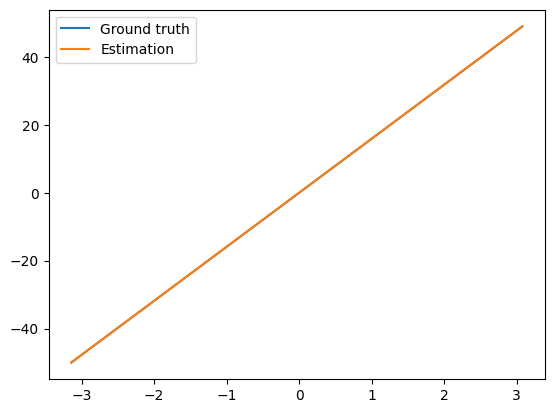

In [ ]:
n=100
x_data = torch.tensor([[np.pi*(2*i/n-1)] for i in range(n)], device=device)
y_data = torch.tensor([(i-n/2) for i in range(n)], device=device).view(-1,1)*(1+0*1j)
m_list = ['Linear']
features = ["X1"]
alpha_list = [10**-30,10**-10]
s_list = [1]
fourier_vector = regression_vector(x_data, y_data, m_list, alpha_list, s_list)
test=t_test(x_data, m_list, alpha_list, s_list, fourier_vector, y_data)

plt.figure()
plt.plot(x_data.view(-1).cpu(), torch.real(y_data.view(-1)).cpu(), label="Ground truth")
plt.plot(x_data.view(-1).cpu(), torch.real(estimation(fourier_vector, x_data, m_list)).view(-1).cpu(), label="Estimation")
plt.legend()
plt.plot()
print("Phi_matrix = "+str(phi_matrix(x_data, m_list)[1:10,:]))
print("Coeff reg = "+str(fourier_vector))
print("std = "+str(np.sqrt(sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data).item())))
print("t_tests="+str(test))
print("Comme attendu, t_test[0] petit car l'offset est nul, et t_test[1] est grand car c'est bien linéaire.")
print_t_test(test, features, m_list)

Phi_matrix = tensor([[1.0000+0.0000j, 0.0314-0.9995j, 0.0314+0.9995j],
        [1.0000+0.0000j, 0.0628-0.9980j, 0.0628+0.9980j],
        [1.0000+0.0000j, 0.0941-0.9956j, 0.0941+0.9956j],
        [1.0000+0.0000j, 0.1253-0.9921j, 0.1253+0.9921j],
        [1.0000+0.0000j, 0.1564-0.9877j, 0.1564+0.9877j],
        [1.0000+0.0000j, 0.1874-0.9823j, 0.1874+0.9823j],
        [1.0000+0.0000j, 0.2181-0.9759j, 0.2181+0.9759j],
        [1.0000+0.0000j, 0.2487-0.9686j, 0.2487+0.9686j],
        [1.0000+0.0000j, 0.2790-0.9603j, 0.2790+0.9603j]], device='cuda:0')
Coeff reg = tensor([[ 2372.6865+1.6056e-06j],
        [-1208.9937+1.2732e+00j],
        [-1208.9935-1.2732e+00j]], device='cuda:0')
std = 42.536377182231476
t_tests=[ 55.78017573+3.77204588e-08j -28.42436909+2.99306801e-02j
 -28.42436283-2.99291896e-02j]
--------------------------
T-tests
Offset: t-test = 55.78017573015606 , significant (5%) = True
Feature X1
Fourier coefficient 0 t-test = 28.4243848450715 , significant (5%) = True
Fourier coe

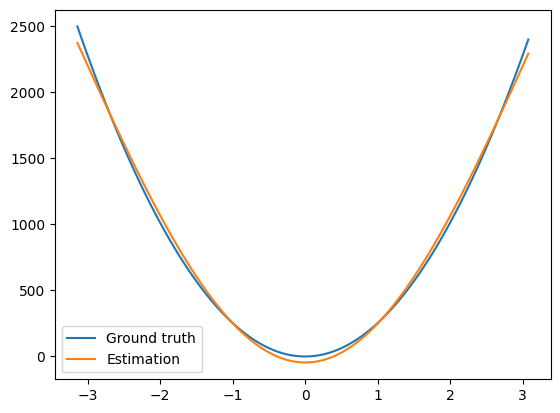

In [ ]:
n=100
x_data = torch.tensor([[np.pi*(2*i/n-1)] for i in range(n)], device = device)
y_data = torch.tensor([(i-n/2)**2 for i in range(n)], device=device).view(-1,1)*(1+0*1j)
m_list = [1]
features = ["X1"]
alpha_list = [10**-30,10**-5]
s_list = [1]
fourier_vector = regression_vector(x_data, y_data, m_list, alpha_list, s_list)
test=t_test(x_data, m_list, alpha_list, s_list, fourier_vector, y_data)

plt.figure()
plt.plot(x_data.view(-1).cpu(), torch.real(y_data.view(-1)).cpu(), label="Ground truth")
plt.plot(x_data.view(-1).cpu(), torch.real(estimation(fourier_vector, x_data, m_list)).view(-1).cpu(), label="Estimation")
plt.legend()
plt.plot()
print("Phi_matrix = "+str(phi_matrix(x_data, m_list)[1:10,:]))
print("Coeff reg = "+str(fourier_vector))
print("std = "+str(np.sqrt(sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data).item())))
print("t_tests="+str(test))
print_t_test(test, features, m_list)

# Test Compet Inde

In [19]:
#data = pd.read_csv('data_corr.csv')
data['DayType']=np.float64(data.loc[:,'DayType'])
data['BH']=np.float64(data.loc[:,'BH'])
n = len(data['Time'])
data['time'] = [i/n*np.pi for i in range(n)]

## PIKL

### Validation

In [171]:
dates_val = {"begin_train": "2017-03-18 00:00:00",
"end_train": "2020-12-18 00:00:00",
"end_test": "2021-01-18 00:00:00"}

features_pikl = {"features1": ['DayType','FTemps95_corr1','Load1D','Load1W', 'Toy', 'time'],
"features2": ['DayType','FTemps95_corr1','Load2D','Load1W', 'Toy', 'time'],
"features_type": ["categorical7", "linear", "regression", "regression", "regression", "linear"]}

features_pikl["features_union"] =  np.union1d(features_pikl["features1"],features_pikl["features2"])


In [172]:
grid_parameters ={
    "grid_size_m": 2,
    "m_ini": 2,
    "grid_size_p": 12,
    "grid_step_p": 0.25,
    "batch_size": 5*10**3
} #La procédure est plus lente en m qu'en p. On peut prendre grid_size_p grand mais pas grid_size_m

n = len(data[(data['Time']>= dates_val["begin_train"])&(data['Time']<dates_val["end_train"])])//24

m_list, alpha_list, s_list, mae, fourier_vectors, mae_h = grid_search_pikl(data, dates_val, features_pikl, n, grid_parameters)

hyperparameters = {"m_list": m_list,
                   "s_list": s_list,
                   "alpha_list": alpha_list,
                   "fourier_vectors": fourier_vectors}

print(hyperparameters["m_list"])
print(hyperparameters["alpha_list"])
print(hyperparameters["s_list"])

0/1953125
15625/1953125
31250/1953125
46875/1953125
62500/1953125
78125/1953125
93750/1953125
109375/1953125
125000/1953125
140625/1953125
156250/1953125
171875/1953125
187500/1953125
203125/1953125
218750/1953125
234375/1953125
250000/1953125
265625/1953125
281250/1953125
296875/1953125
312500/1953125
328125/1953125
343750/1953125
359375/1953125
375000/1953125
390625/1953125
406250/1953125
421875/1953125
437500/1953125
453125/1953125
468750/1953125
484375/1953125
500000/1953125
515625/1953125
531250/1953125
546875/1953125
562500/1953125
578125/1953125
593750/1953125
609375/1953125
625000/1953125
640625/1953125
656250/1953125
671875/1953125
687500/1953125
703125/1953125
718750/1953125
734375/1953125
750000/1953125
765625/1953125
781250/1953125
796875/1953125
812500/1953125
828125/1953125
843750/1953125
859375/1953125
875000/1953125
890625/1953125
906250/1953125
921875/1953125
937500/1953125
953125/1953125
968750/1953125
984375/1953125
1000000/1953125
1015625/1953125
1031250/1953125
104

--------------------------
T-tests
Offset: t-test = 5.192814618689679 , significant (5%) = True
Feature DayType
Fourier coefficient 0 t-test = 0.27173539499956306 , significant (5%) = False
Fourier coefficient 1 t-test = 1.131993671797111 , significant (5%) = False
Fourier coefficient 2 t-test = 1.9258220237925594 , significant (5%) = False
Fourier coefficient 3 t-test = 2.4151016821742433 , significant (5%) = True
Fourier coefficient 4 t-test = 2.317699025587497 , significant (5%) = True
Fourier coefficient 5 t-test = 1.7254541909985956 , significant (5%) = False
Fourier coefficient 6 t-test = 0.9783346109886936 , significant (5%) = False
Fourier coefficient 7 t-test = 0.2278418772751035 , significant (5%) = False
Feature FTemps95_corr1
Linear coefficient t-test = 0.298179050302486 , significant (5%) = False
Feature Load2D
Fourier coefficient 0 t-test = 0.2397310577936685 , significant (5%) = False
Fourier coefficient 1 t-test = 0.46281606227452365 , significant (5%) = False
Fourier c

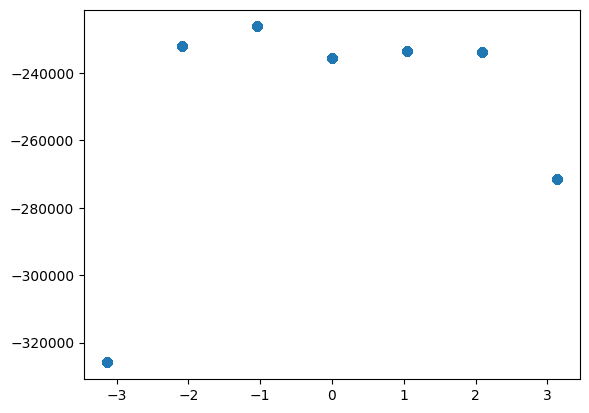

FTemps95_corr1


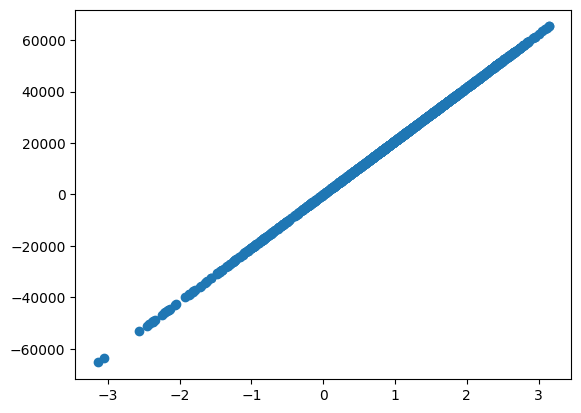

Load2D


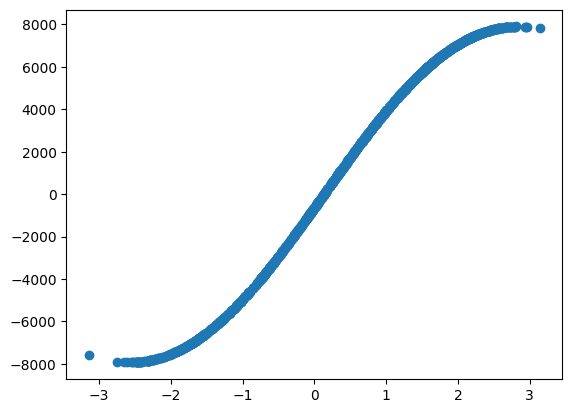

Load1W


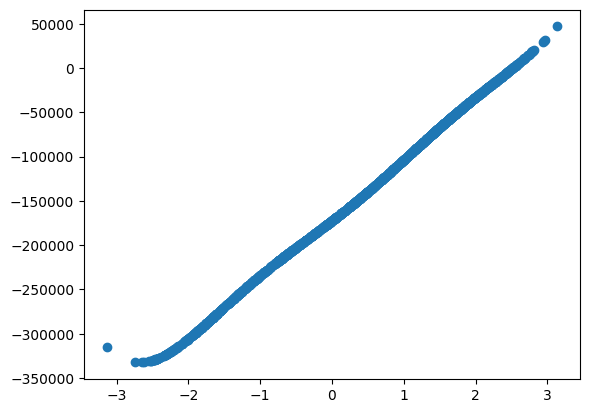

Toy


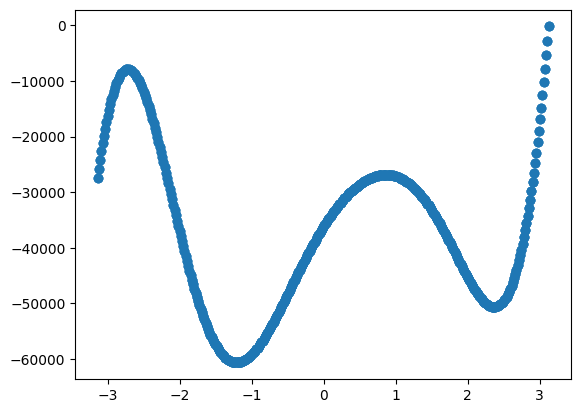

time


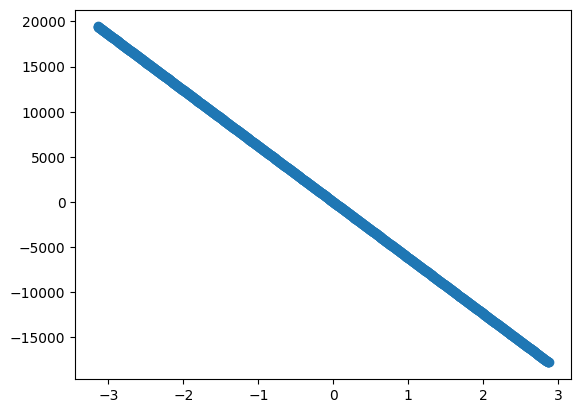

In [173]:
print_effect(data, dates_val, features_pikl, hyperparameters, fourier_vectors, 10)

The mean MAE offline is 20501.303


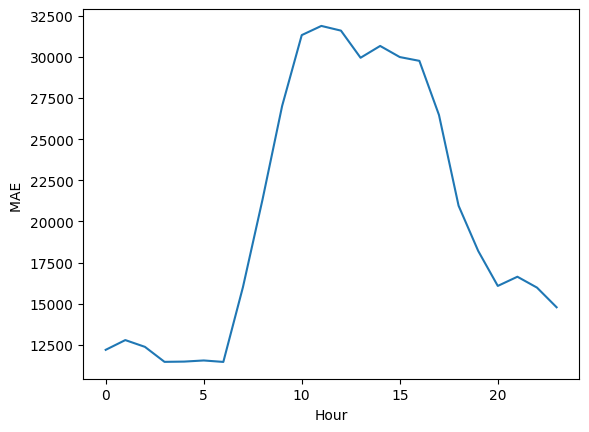

In [174]:
print("The mean MAE offline is "+str(mae.cpu().numpy()))

plt.figure()
plt.plot(np.array([i for i in range(24)]), np.array(mae_h.cpu()))
plt.xlabel("Hour")
plt.ylabel("MAE ")
plt.show()

### Test

In [175]:
dates_test = {"begin_train": "2017-03-18",
"end_train": "2021-01-18",
"end_test": "2021-02-17 00:00:00"}

In [176]:
data_hourly = hour_formatting(data, dates_test, features_pikl)
cov_hourly = cov_hourly_m(m_list, data_hourly)
sobolev_matrix = Sob_matrix(alpha_list, s_list, m_list)*len(data_hourly[0][0])
M_stacked = torch.stack([sobolev_matrix for i in range(24)])
mae_test, fourier_vectors_test, mae_h_test = PIKL(data, hyperparameters, cov_hourly, M_stacked)

The mean MAE offline is 15695.979


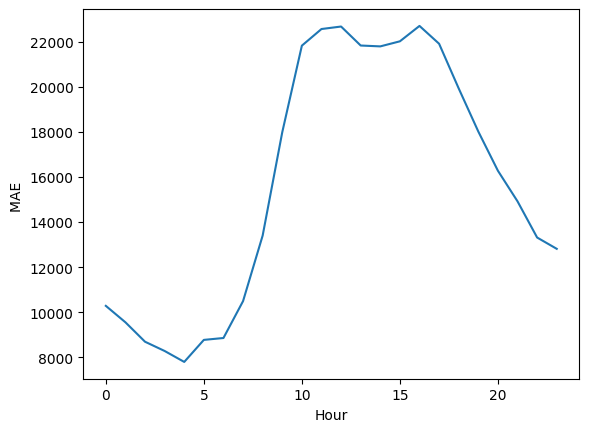

In [177]:
print("The mean MAE offline is "+str(mae_test.cpu().numpy()))

plt.figure()
plt.plot(np.array([i for i in range(24)]), np.array(mae_h_test.cpu()))
plt.xlabel("Hour")
plt.ylabel("MAE ")
plt.show()

## Time-varying PIKL

### Validation

In [178]:
hyperparameters["window"] = 1
dates_val_online = dates_val.copy()
dates_val_online["begin_train"] = "2020-03-01 00:00:00"

n = len(data[(data['Time']>= dates_val_online["begin_train"])&(data['Time']<dates_val_online["end_train"])])//24
features_pikl["features_type_online"] = ["regression" for i in range(6)]
grid_size = 0
tunable_parameters = ["p"]

In [179]:
m_online, power_online, s_online, mae_list_opt = grid_search_pikl_online(data, dates_val_online, features_pikl, hyperparameters, n, grid_size, tunable_parameters)

0/1


(2, 2, 2, 2, 2, 2)
(-30, -2, -2, -2, -2, -2, -2)
[2, 2, 2, 2, 2, 2]
15935.255249023438


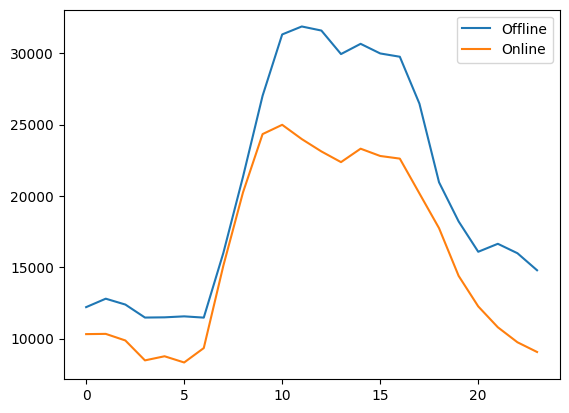

In [180]:
print(m_online)
print(power_online)
print(s_online)
print(np.mean(mae_list_opt))
plt.plot(np.array([i for i in range(24)]), mae_h.cpu().numpy(), label="Offline")
plt.plot(range(0,24), mae_list_opt, label="Online")
plt.legend()

### Test

In [181]:
alpha_online = [10**power for power in power_online]
dates_test_online = dates_test.copy()
dates_test_online["begin_train"] =  "2020-03-01 00:00:00"
hyperparameters_online={"m_list_online": m_online,
                         "power_list_online": power_online,
                         "s_list_online": s_online,
                         "alpha_list_online": alpha_online}

data_hourly = hour_formatting_online(data, dates_test_online, features_pikl, hyperparameters)
cov_hourly = cov_hourly_online(m_online, data_hourly)
mae_online = PIKL_online(data, hyperparameters_online, data_hourly, cov_hourly)

The mean MAE online is 10739.302795410156
15695.979


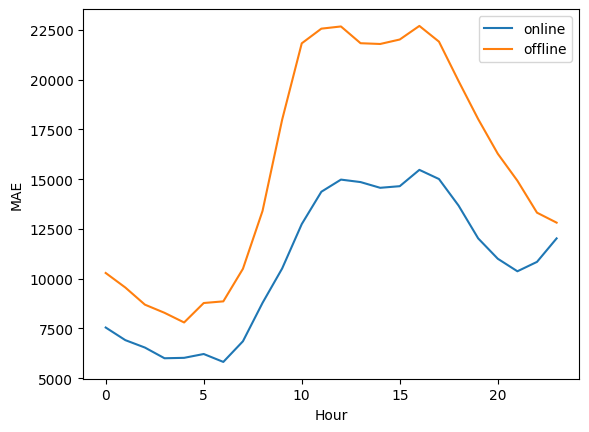

In [182]:
print("The mean MAE online is "+str(np.mean(mae_online)))
print(mae_test.cpu().numpy())

plt.figure()
plt.plot(np.array([i for i in range(24)]), np.array(mae_online), label="online")
plt.plot(np.array([i for i in range(24)]), mae_h_test.cpu(), label="offline")
plt.xlabel("Hour")
plt.ylabel("MAE")
plt.legend()
plt.show()

# Pistes améliorations
## Tensorisation de la grid search online

In [ ]:
#test tensorisation
import time
l,p = 25, 1000

time1, time2, time3 = 0, 0, 0

for i in range(p):
  list_cov = [torch.rand(l,l, device=device) for i in range(30)]
  list_cov = [A+A.T for A in list_cov]
  list_cov2 = [torch.rand(l,l, device=device) for i in range(30)]
  list_cov2 = [A+A.T for A in list_cov2]
  list_vect = [torch.rand(l, device=device) for i in range(30)]

  t1 = time.time()
  m = [torch.linalg.solve(list_cov[i]@list_cov2[i],list_vect[i]) for i in range(30)]
  t2 = time.time()
  time1+= t2-t1

  t1 = time.time()

  list_cov = torch.stack(list_cov)
  list_cov2 = torch.stack(list_cov2)
  list_vect = torch.stack(list_vect)

  t2 = time.time()
  time2+= t2-t1
  t1 = time.time()

  m2 = torch.linalg.solve(torch.bmm(list_cov, list_cov2), list_vect)
  t2 = time.time()
  time3+= t2-t1

print(time1/p)
print(time2/p)
print(time3/p)

0.007442404747009277
0.00024072742462158202
0.00042768502235412595


In [ ]:
#test tensorisation complexe
l,p = 25, 1000

time1, time2, time3 = 0, 0, 0

for i in range(p):
  list_cov = [torch.rand(l,l, device=device) for i in range(30)]
  list_cov = [(A+A.T)*(1.+0*1j) for A in list_cov]
  list_cov2 = [torch.rand(l,l, device=device) for i in range(30)]
  list_cov2 = [(A+A.T)*(1.+0*1j) for A in list_cov2]
  list_vect = [torch.rand(l, device=device)*(1.+0*1j) for i in range(30)]

  t1 = time.time()
  m = [torch.linalg.solve(list_cov[i]@list_cov2[i],list_vect[i]) for i in range(30)]
  t2 = time.time()
  time1+= t2-t1

  t1 = time.time()

  list_cov = torch.stack(list_cov)
  list_cov2 = torch.stack(list_cov2)
  list_vect = torch.stack(list_vect)

  t2 = time.time()
  time2+= t2-t1
  t1 = time.time()

  m2 = torch.linalg.solve(torch.bmm(list_cov, list_cov2), list_vect)
  t2 = time.time()
  time3+= t2-t1

print(time1/p)
print(time2/p)
print(time3/p)

0.005550933361053467
0.0001650857925415039
0.0002573626041412354


Conclusion: on s'attend à gagner un rapport x20 en tensorisant. Le fait de travailler avec des complexes ne change rien.

## Stockage de la matrice de Sobolev

In [ ]:
l,p = 50, 10000

alpha_list = [1e-30, 1e-30, 1e-30, 1, 0.0001, 1e-06, 1e-30]
s_list = [0, '*', 2, 2, 2, '*']
m_list = [4, 'Linear', 5, 5, 5, 'Linear']

t1 = time.time()
for i in range(p):
    s = Sob_matrix(alpha_list, s_list, m_list)
t2 = time.time()
print((t2-t1)/p)

one_list = [1. for i in range(7)]
select_dim = [[0 for i in range(7)] for i in range(7)]
for i in range(7):
    select_dim[i][i] = 1


s1 = Sob_matrix(one_list, s_list, m_list)
s2 = []
for i in range(7):
    s2.append(Sob_matrix(select_dim[i], s_list, m_list))
s2 = torch.stack(s2)
alpha_tensor = torch.tensor(alpha_list, device=device).view(-1,1, 1)

t1 = time.time()
for i in range(p):
    mul = torch.sum(alpha_tensor * s2, dim=0)
t2 = time.time()
print((t2-t1)/p)

print(torch.linalg.norm(mul-s))

0.0010300350666046143
2.7399086952209474e-05
tensor(0., device='cuda:0')


On gagne ainsi un facteur x100.

## Compute time mean

In [ ]:
data_time ="""1: 7.152557373046875e-07
2: 0.0011959075927734375
3: 0.000240325927734375
4: 0.0008561611175537109
5: 0.0016624927520751953
1: 1.1920928955078125e-06
2: 0.0012302398681640625
3: 0.00014710426330566406
4: 0.0001068115234375
5: 0.0034999847412109375
1: 1.1920928955078125e-06
2: 0.0012936592102050781
3: 0.00010180473327636719
4: 9.584426879882812e-05
5: 0.0009753704071044922
1: 9.5367431640625e-07
2: 0.002065420150756836
3: 0.0008096694946289062
4: 0.0007905960083007812
5: 0.0010020732879638672
1: 9.5367431640625e-07
2: 0.0021522045135498047
3: 0.00012421607971191406
4: 0.0008122920989990234
5: 0.0010039806365966797
1: 2.384185791015625e-06
2: 0.0016279220581054688
3: 0.0008382797241210938
4: 9.751319885253906e-05
5: 0.000713348388671875
1: 9.5367431640625e-07
2: 0.002080202102661133
3: 0.00047850608825683594
4: 0.0007867813110351562
5: 0.0015518665313720703
1: 1.9073486328125e-06
2: 0.0021049976348876953
3: 0.00010204315185546875
4: 0.0008227825164794922
5: 0.0014252662658691406
1: 9.5367431640625e-07
2: 0.002107381820678711
3: 0.0008533000946044922
4: 0.0007851123809814453
5: 0.0011875629425048828
1: 1.1920928955078125e-06
2: 0.0021169185638427734
3: 0.0008265972137451172
4: 9.870529174804688e-05
5: 0.0010311603546142578
1: 1.1920928955078125e-06
2: 0.0021867752075195312
3: 0.0008649826049804688
4: 0.0008325576782226562
5: 0.0014998912811279297
1: 7.152557373046875e-07
2: 0.002133607864379883
3: 0.0008599758148193359
4: 0.0003349781036376953
5: 0.0014562606811523438
1: 1.1920928955078125e-06
2: 0.0007014274597167969
3: 0.0007491111755371094
4: 0.0007560253143310547
5: 0.0014309883117675781
1: 1.1920928955078125e-06
2: 0.0016100406646728516
3: 0.0008573532104492188
4: 0.0003066062927246094
5: 0.0013844966888427734
1: 9.5367431640625e-07
2: 0.0019125938415527344
3: 0.0008234977722167969
4: 0.0008590221405029297
5: 0.0013427734375
1: 1.1920928955078125e-06
2: 0.0019180774688720703
3: 0.0007674694061279297
4: 0.0007991790771484375
5: 0.0009300708770751953
1: 9.5367431640625e-07
2: 0.0019414424896240234
3: 0.000766754150390625
4: 0.0007278919219970703
5: 0.0014028549194335938
1: 9.5367431640625e-07
2: 0.0016918182373046875
3: 0.0007824897766113281
4: 9.584426879882812e-05
5: 0.0013201236724853516
1: 1.430511474609375e-06
2: 0.0018756389617919922
3: 0.0007646083831787109
4: 0.0007431507110595703
5: 0.001318216323852539
1: 1.1920928955078125e-06
2: 0.0021398067474365234
3: 0.00012922286987304688
4: 0.00037598609924316406
5: 0.0008766651153564453
1: 9.5367431640625e-07
2: 0.0019001960754394531
3: 0.0007698535919189453
4: 0.00081634521484375
5: 0.0008552074432373047
1: 9.5367431640625e-07
2: 0.0015106201171875
3: 0.0007579326629638672
4: 0.0007228851318359375
5: 0.000759124755859375
1: 1.1920928955078125e-06
2: 0.001977205276489258
3: 0.0007576942443847656
4: 9.107589721679688e-05
5: 0.0013422966003417969
1: 4.76837158203125e-07
2: 0.0014276504516601562
3: 0.0007777214050292969
4: 0.0007419586181640625
5: 0.0013165473937988281"""

lines = data_time.strip().split('\n')
values = {1: [], 2: [], 3: [], 4: [], 5:[], 6:[]}

# Group values by the number (1, 2, 3, 4)
for i in range(0, len(lines)):
    key = int(lines[i].split(":")[0])
    value = float(lines[i].split()[1])
    values[key].append(value)

# Calculate the mean for each group
means = {k: np.mean(v) for k, v in values.items()}

# Display the results
for key, mean in means.items():
    print(f'Mean for value {key}: {mean}')

Mean for value 1: 1.1225541432698567e-06
Mean for value 2: 0.0017875730991363525
Mean for value 3: 0.00062293807665507
Mean for value 4: 0.0005606710910797119
Mean for value 5: 0.0013036926587422688
Mean for value 6: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
